In [1]:
import os
import sys
os.chdir('..')
sys.path.append(os.getcwd())

In [2]:
import torch
from Models.pretrain import *
from Models.cPB import cPB
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
import argparse
from torch.autograd import Variable
import pprint
import copy
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='torch.storage')
warnings.filterwarnings("ignore", category=UserWarning, module='torch.storage')
warnings.filterwarnings("ignore", category=DeprecationWarning, module='torch.storage')

# SINE datasets


In [3]:
base_model = 'GRU'
batch_size = 128
hidden_size = 250
seq_len = 10
epoch_size=10
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
input_size=2
iteration=1
mask_init='uniform'
dataset='SINE'
dataset_name = "sine_rw10_mode5_extended_16-16_1234"
Pretrain_task = '1'

df = pd.read_csv(os.path.join(f"datasets/{dataset}/", f"{dataset_name}.csv"))
pretrain_model_addr=f'Performance/Pretrain/GRU/{dataset}/After/sine-6_6-1234-t{Pretrain_task}-{base_model}-pretrain-hidden{hidden_size}-epoch10_itter{iteration}.pickle'
mask_weights=[] #if we have initial masks then reload it here



In [ ]:
model=cPB(lr = lr ,hidden_size=hidden_size, seq_len=seq_len,base_model=base_model, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size,input_size=input_size)


for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index,task,mask_selection=True)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column(task)
        model.predict_many(x,y,best_mask_index,task,mask_selection=False)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index,task,mask_selection=False)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


file_path = f'Performance/Results/cPB/{dataset}/pretrain-T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10_iter{iteration}.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model.performance, file)

file_path = f'Performance/Results/cPB/{dataset}/pretrain-T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10_iter{iteration}_selectedMask.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model.selected_mask_index, file)


# Weather datasets


In [6]:
base_model = 'GRU'
batch_size = 128
hidden_size = 250
seq_len = 11
epoch_size=10
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
input_size=4
iteration=1
mask_init='uniform'
dataset='Weather'
dataset_name = "weather_st124_4conf"
Pretrain_task = '1'

df = pd.read_csv(os.path.join(f"datasets/{dataset}/", f"{dataset_name}.csv"))
pretrain_model_addr=f'Performance/Pretrain/GRU/{dataset}/After/weather-{base_model}-pretrain-hidden{hidden_size}-epoch10_itter{iteration}.pickle'
mask_weights=[] #if we have initial masks then reload it here



list of accuracies that used for evaluating and selecting the models =  [0.82828125]
list of kappa values that used for evaluating and selecting the models =  [0.6541676]
index of selcted mask for this task 0
All batches Accuracy=  0.8918223202334921
All batches cohen kappa=  0.7817067760156422
list of accuracies that used for evaluating and selecting the models =  [0.58546875 0.6153125 ]
list of kappa values that used for evaluating and selecting the models =  [0.17152901 0.22161603]
index of selcted mask for this task 1
All batches Accuracy=  0.724562899687686
All batches cohen kappa=  0.44478092164584865
list of accuracies that used for evaluating and selecting the models =  [0.71421875 0.8578125  0.80984375]
list of kappa values that used for evaluating and selecting the models =  [0.43018618 0.71446937 0.61605873]
index of selcted mask for this task 1
All batches Accuracy=  0.862966379759072
All batches cohen kappa=  0.7230037094162005
list of accuracies that used for evaluating a

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:280: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


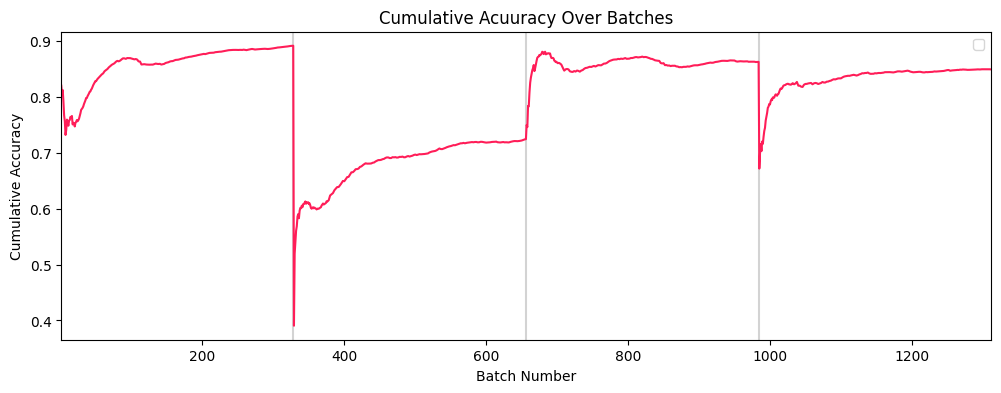

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:297: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


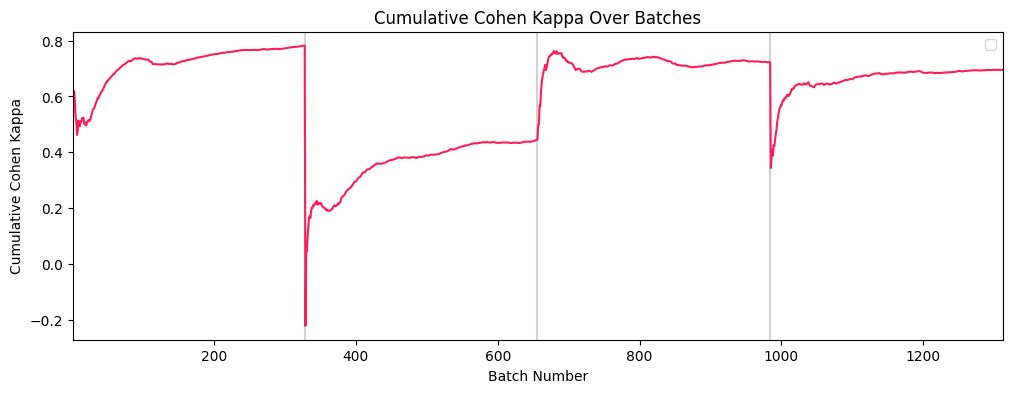

In [7]:
model=cPB(lr = lr ,hidden_size=hidden_size, seq_len=seq_len,base_model=base_model, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size,input_size=input_size)


for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index,task,mask_selection=True)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column(task)
        model.predict_many(x,y,best_mask_index,task,mask_selection=False)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index,task,mask_selection=False)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


file_path = f'Performance/Results/cPB/{dataset}/pretrain-T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10_iter{iteration}.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model.performance, file)

file_path = f'Performance/Results/cPB/{dataset}/pretrain-T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10_iter{iteration}_selectedMask.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model.selected_mask_index, file)
